In [73]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *

In [74]:
def delta(v_t_fire):
    if v_t_fire == 1.:
        return 1
    else:
        return 0

def simple_REI_model(r_t, e_t, ina_t, u_t, t_rec, t_ina, t_fac, U, dt, v_t_fire):
    du = - u_t / t_fac + U * (1 - u_t) * delta(v_t_fire) *(1/dt)
    u_t = u_t + du * dt
    
    dr = ina_t / t_rec - u_t * r_t * delta(v_t_fire) *(1/dt)
    de = - e_t / t_ina + u_t * r_t * delta(v_t_fire) * (1/dt)
    dina = e_t / t_ina - ina_t / t_rec
    
    r_t_ = r_t + dr * dt
    e_t_ = e_t + de * dt
    ina_t_ = ina_t + dina * dt

    r_t_ = r_t_ /(r_t_ + e_t_ + ina_t_)
    e_t_ = e_t_ /(r_t_ + e_t_ + ina_t_)
    ina_t_ = ina_t_ /(r_t_ + e_t_ + ina_t_)
    return r_t_, e_t_, ina_t_, u_t

def IF_neuron(v_t, t_mem, R_mem, I_syn, I_ext, dt, v_t_fire, current_time, i_th_neuron):
    dv = (- v_t + R_mem * (I_syn + I_ext)) / t_mem
    v_t_ = v_t + dv * dt
    if v_t_ >= 15.:
        v_t_ = 13.5
        v_t_fire[i_th_neuron, current_time] = 1.
        #print("neuron fired !")
    
    return v_t_

def raster(event_times_list, **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

In [75]:
A_ij = np.empty((0, 30))
for i in range(27):
    tmp = np.zeros((1,30))
    for j in range(30):
        if randint(4) % 4 == 1:
            if j<27:
                tmp[0, j] = 18
            else:
                tmp[0, j] = 54
    A_ij = np.append(A_ij, tmp, axis = 0)
for i in range(3):
    tmp = np.zeros((1, 30))
    for j in range(30):
        if randint(4) % 4 == 1:
            tmp[0, j] = 72
    A_ij = np.append(A_ij, tmp, axis = 0)
#print(A_ij.dtype)
#print(A_ij.shape)
#print(A_ij)

In [76]:
R_mem_i = np.ones(30)
"""
for i in range(30):
    R_mem_i[i] = np.random.uniform(high = 0.7, low = 0.2, size =1)
"""

'\nfor i in range(30):\n    R_mem_i[i] = np.random.uniform(high = 0.7, low = 0.2, size =1)\n'

In [90]:
r = 0.5
e = 0.5
ina = 1 - r - e
u = 0.02

#second
t_rec = 0.2
t_ina = 0.01
t_fac = 3
t_mem = 0.03

U_e = 0.5
U_i = 0.04

I_ext_i = np.zeros(30)
for i in range(30):
    I_ext_i[i] = np.random.normal(loc = 13 - 0.05, scale = 13 + 0.05, size = 1)

dt = 0.0001

T = 10 * (1/dt)
intT = int(T)

time = np.zeros(intT)

v_t = np.zeros((30, intT))
v_t_fire = np.zeros((30, intT))
r_t = np.zeros((intT, 30, 30))
e_t = np.zeros((intT, 30, 30))
ina_t = np.zeros((intT, 30, 30,))
u_t = np.zeros((intT, 30, 30))

# for debugging
I_syn = np.zeros(intT)

v_t[:,0] = 14.
r_t[0, :, :] = r
e_t[0, :, :] = e
ina_t[0, :, :] = ina
u_t[0, :, :] = u

for t in range(intT - 1):
    # this is i * dt mili second
    time[t+1] = t * dt

    if t % 10000 == 0:
        print("this is time {}".format(t * dt))
    for i in range(30):
        # calculate the variable of i_th neuron
        I_syn_i = 0.
        if (t +1) % 10 == 0:
            I_ext_i[i] = np.random.normal(loc = 12 - 0.05, scale = 12 + 0.05, size = 1)
        for j in range(30):
            # j_th synapse of i_th neuron
            # calculate I_syn = sum_of A_ij * e_t_ij
            if j == i:
                pass
            else:
                #if i == 0:
                #    print("{} I_syn_{}".format(A_ij[j, i] * e_t[t, j, i], i))
                #    print("{} e_{}".format(e_t[t, :, :],t))
                #    print("{} r_t[t, i, j], {} e_t[t, i, j], {} ina_t[t, i, j], {} u_t[t, i, j]".format(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j]))
                if i < 27:
                    r_t[t+1, i, j], e_t[t+1, i, j], ina_t[t+1, i, j], u_t[t+1, i, j] = simple_REI_model(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j], t_rec, t_ina, t_fac, U_e, dt, v_t_fire[i, t])
                else:
                    r_t[t+1, i, j], e_t[t+1, i, j], ina_t[t+1, i, j], u_t[t+1, i, j] = simple_REI_model(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j], t_rec, t_ina, t_fac, U_i, dt, v_t_fire[i, t])
            I_syn_i += A_ij[j, i] * e_t[t, j, i]
        #if i == 0:
        #    print("{} I_syn_i total".format(I_syn_i))
        v_t[i, t+1] = IF_neuron(v_t[i, t], t_mem, R_mem_i[i], I_syn_i, I_ext_i[i], dt, v_t_fire, t, i)  
    if t == intT - 2:
        print("this is time {}\ndone !".format((t + 2)* dt))

this is time 0.0
this is time 1.0
this is time 2.0
this is time 3.0
this is time 4.0
this is time 5.0
this is time 6.0
this is time 7.0
this is time 8.0
this is time 9.0
this is time 10.0
done !


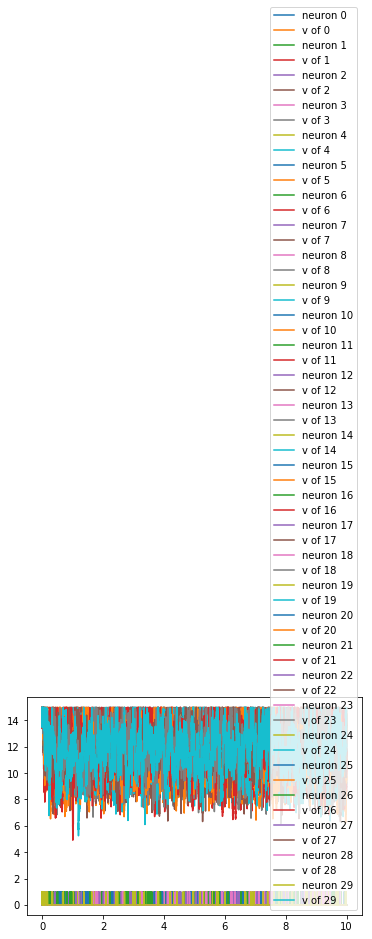

In [91]:
#plt.plot(time, v_t_fire[0, :], label='neuron1')
#plt.plot(time, v_t_fire[1, :], label='neuron2')
#plt.plot(time, u_t[:, 0, 0], label='u_t')

for i in range(30):
    plt.plot(time, v_t_fire[i, :], label='neuron {}'.format(i))
    plt.plot(time, v_t[i, :], label='v of {}'.format(i))

plt.legend(loc="lower right")

/Users/soliton/.pyenv/versions/anaconda3-4.2.0/envs/dynamicsenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


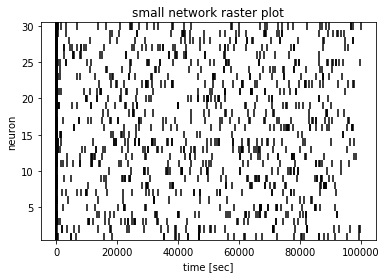

In [92]:
spikes = []

for j in range(30):
    spike = []
    for i in range(intT):
        if v_t_fire[j,i] == 1:
            spike.append(i)
            #print("{}th neuron fired spike appended".format(j))
    spikes.append(spike)
            
fig = plt.figure()
ax = raster(spikes)
plt.title('small network raster plot')
plt.xlabel('time [sec]')
plt.ylabel('neuron')
fig.show()

plt.savefig('small_netwrok_ruster_A++.png')

In [35]:
A_ij = np.empty((0, 30))
for i in range(27):
    tmp = np.zeros((1,30))
    for j in range(30):
        if randint(4) % 4 == 1:
            if j<27:
                tmp[0, j] = 18
            else:
                tmp[0, j] = 54
    A_ij = np.append(A_ij, tmp, axis = 0)
for i in range(3):
    tmp = np.zeros((1, 30))
    for j in range(30):
        if randint(4) % 4 == 1:
            tmp[0, j] = -72
    A_ij = np.append(A_ij, tmp, axis = 0)
#print(A_ij.dtype)
#print(A_ij.shape)
#print(A_ij)

In [36]:
r = 0.5
e = 0.5
ina = 1 - r - e
u = 0.02

#mili second
t_rec = 200
t_ina = 10
t_fac = 3000

U_e = 0.5
U_i = 0.04

I_ext_i = np.zeros(30)
for i in range(30):
    I_ext_i[i] = np.random.normal(loc = 15 - 0.05, scale = 15 + 0.05, size = 1)

t_mem = 30

dt = 0.01

T = 2000 * (1/dt)
intT = int(T)

time = np.zeros(intT)

v_t = np.zeros((30, intT))
v_t_fire = np.zeros((30, intT))
r_t = np.zeros((intT, 30, 30))
e_t = np.zeros((intT, 30, 30))
ina_t = np.zeros((intT, 30, 30,))
u_t = np.zeros((intT, 30, 30))

# for debugging
I_syn = np.zeros(intT)

v_t[:,0] = 14.
r_t[0, :, :] = r
e_t[0, :, :] = e
ina_t[0, :, :] = ina
u_t[0, :, :] = u

for t in range(intT - 1):
    # this is i * dt mili second
    time[t+1] = t * dt

    if t % 10000 == 0:
        print("this is time {}".format(t * dt))
    for i in range(30):
        # calculate the variable of i_th neuron
        I_syn_i = 0.
        if (t +1) % 100 == 0:
            I_ext_i[i] = np.random.normal(loc = 15 - 0.05, scale = 15 + 0.05, size = 1)
        for j in range(30):
            # j_th synapse of i_th neuron
            # calculate I_syn = sum_of A_ij * e_t_ij
            if j == i:
                pass
            else:
                #if i == 0:
                #    print("{} I_syn_{}".format(A_ij[j, i] * e_t[t, j, i], i))
                #    print("{} e_{}".format(e_t[t, :, :],t))
                #    print("{} r_t[t, i, j], {} e_t[t, i, j], {} ina_t[t, i, j], {} u_t[t, i, j]".format(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j]))
                if i < 27:
                    r_t[t+1, i, j], e_t[t+1, i, j], ina_t[t+1, i, j], u_t[t+1, i, j] = simple_REI_model(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j], t_rec, t_ina, t_fac, U_e, dt, v_t_fire[i, t])
                else:
                    r_t[t+1, i, j], e_t[t+1, i, j], ina_t[t+1, i, j], u_t[t+1, i, j] = simple_REI_model(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j], t_rec, t_ina, t_fac, U_i, dt, v_t_fire[i, t])
            I_syn_i += A_ij[j, i] * e_t[t, j, i]
        #if i == 0:
        #    print("{} I_syn_i total".format(I_syn_i))
        v_t[i, t+1] = IF_neuron(v_t[i, t], t_mem, R_mem_i[i], I_syn_i, I_ext_i[i], dt, v_t_fire, t, i)  

this is time 0.0
this is time 100.0
this is time 200.0
this is time 300.0
this is time 400.0
this is time 500.0
this is time 600.0
this is time 700.0
this is time 800.0
this is time 900.0
this is time 1000.0
this is time 1100.0
this is time 1200.0
this is time 1300.0
this is time 1400.0
this is time 1500.0
this is time 1600.0
this is time 1700.0
this is time 1800.0
this is time 1900.0


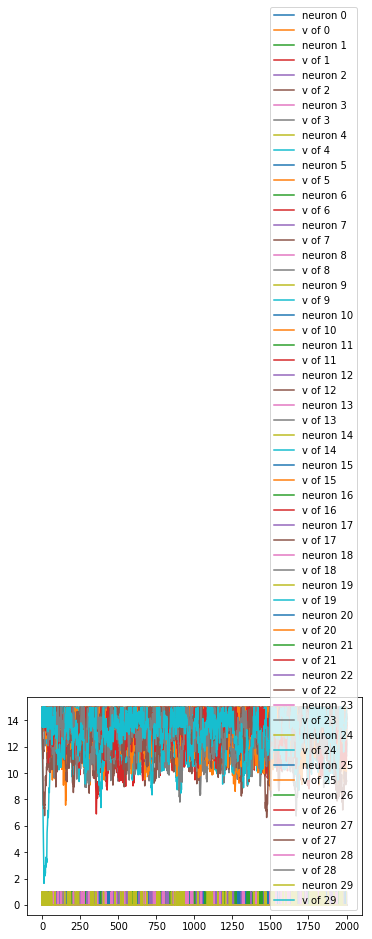

In [37]:
for i in range(30):
    plt.plot(time, v_t_fire[i, :], label='neuron {}'.format(i))
    plt.plot(time, v_t[i, :], label='v of {}'.format(i))

plt.legend(loc="lower right")

/Users/soliton/.pyenv/versions/anaconda3-4.2.0/envs/dynamicsenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


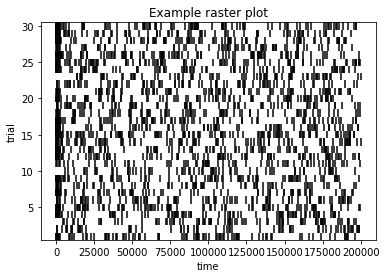

In [38]:
spikes = []

for j in range(30):
    spike = []
    for i in range(intT):
        if v_t_fire[j,i] == 1:
            spike.append(i)
            #print("{}th neuron fired spike appended".format(j))
    spikes.append(spike)
            
fig = plt.figure()
ax = raster(spikes)
plt.title('Example raster plot')
plt.xlabel('time')
plt.ylabel('trial')
fig.show()